    221025_exnode12_text_summerization
        1. package load
        2. data load 
        3. text pre action :정규화사전 및 불용어 리스트 준비
        4. 훈련데이터와 테스트데이터 나누기 
           - 샘플의 최대 길이 정하기 : 98360 -> 94737
           - 시작 토큰과 종료 토큰 추가하기
           - 훈련 데이터와 테스트 데이터 분리(8:2)
        5. 정수 인코딩
           - 단어 집합(vocabulary)
           - padding            
        6. 모델 설계
           - encoder, decoder 
        7. 모델 훈련 
           - compile & fit, 시각화
        8. 인퍼런스 모델 
        9. 모델 테스트
       10. 추출적 요약
       11. 결론 -------------------------------------------------------
           -. 테스트 정규화, 불용어 제거, 특수문자 제거를 통해 모델 학습을 원할하게 수행하였습니다.
           -. 추상적 요약이 에러없이 수행 되었으며,적절한 headline 추출이 되었다고 생각됨. 
           -. 추출적 요약이 성공적으로 수행되었으나, 적절한 headline 추출이 되었다고 생각됨. 
           -. 비교        :    문법완성도             핵심단어 포함 측면           
            . 추상적 요약 :      미흡                      보통
            . 추출적 요약 :      양호                      보통
            . 추출적 요약은 문법 완성도 측면에서 양호하였으나 핵심단어측면에서는 양 모델이 보통으로 평가됨.
              추상적 요약에 대한 학습이 hypre parameter 변경을 통한 정확도 향상이 필요하다고 판단 됨.
           -. 추상적 요약에 대한 모델 이해도를 더욱 높여서 진행시켜야 할 듯합니다.
              아쉬운 결과이지만 모델 hyper parameter의 이해도를 높여야 할 것 같습니다.       

In [1]:
#1. package load
from importlib.metadata import version
import tensorflow
import summa
import pandas as pd
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

#print(nltk.__version__)
#print(tensorflow.__version__)
#print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


    2. data load : 98401(headlines ,text) 
        - Text 자체가 중복이 된 경우는 중복 샘플(중복제거 : 41개) : 98360
        - null 제거 : 0개

In [62]:
#2. data load 
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [63]:
#2. data load  .. 확인
data_summarize = data

print(len(data))
data.sample(10)

98401


,headlines,text
56050,"Not a feminist, find men superior to women: Pa...","Prernaa Arora, who is co-producing the Akshay ..."
79608,Air India's net loss declined by Ã¢ÂÂ¹194 cro...,Air India's net loss in 2016-17 stood at Ã¢ÂÂ...
34155,Migrants sent record $466 billion home in 2017...,The world's 266 million migrant workers from m...
20892,26/11 mastermind's half-brother in Pak team fo...,The half-brother of 26/11 Mumbai attack master...
95054,World Wide Web inventor wins computing's highe...,World Wide Web inventor Tim Berners-Lee has wo...
17690,Real Madrid's 18-yr-old player scores bicycle ...,Real Madrid's 18-year-old Brazilian attacker V...
58118,"Bharti Singh, Haarsh Limbachiyaa get married i...",Comedian Bharti Singh and television script wr...
56954,"Will make sure AbRam, Taimur work together: SR...",While talking about his son AbRam and Kareena ...
71337,Moons of Uranus on a collision course: Study,US-based researchers have found evidence that ...
4055,Rahul Gandhi desperate to see Gujarat's failur...,Gujarat CM Vijay Rupani on Sunday tweeted that...


In [4]:
# 2 data load  :   중복 샘플과 NULL 값이 존재하는 샘플 제거  ..
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
#2 data load  :  Text 자체가 중복이 된 경우는 중복 샘플
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
# 2 data load  :   Null 값이 있는지 확인 ... 
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
##2.  data load.. data_summarize 생성
data_summarize0 = data

    3. text pre action : 정규화사전 및 불용어 리스트 준비
       - 정규화사전정의 : 120개  
         * 텍스트 정규화(동일 의미 제거)
       - 불용어 리스트  : 179개
       - 데이터 전처리 함수 정의
       - 텍스트 정규화 및 불용어 제거 실행

In [8]:
#  3. text pre action  .. 텍스트 정규화(동일 의미)  .. 정규화사전정의 120개
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
##  3. text pre action  ..  NLTK에서 제공하는 불용어 리스트 .. 179개
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
#  3. text pre action  .. text , 불용어 제거 함수 
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [11]:
##  3. text pre action  .. Text를 전처리하고, 결과를 확인
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
##  3. text pre action  ..headlines 전처리하고, 결과를 확인 ... 불용어는 skip : false
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
##  3. text pre action .. data_summarize 생성
data_summarize1 = data

In [14]:
##  3. text pre action  ... empty sample 확인 및 제거  ... list  data 저장 .. 저장 후 null 제거 
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [15]:
##  3. text pre action  ... empty sample 확인 및 제거 
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [16]:
##  3. text pre action  ... empty sample 확인 및 제거 
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


    4. 훈련데이터와 테스트데이터 나누기
       - 샘플의 최대 길이 정하기 : 98360 -> 94737
        . text      : 42 ( 이하 샘플의 비율: 97.5 % )
        . headlines : 12 ( 이하인 샘플의 비율: 98.8 % )
        . headlines :  4 ( 이하인 샘플의 비율: 0.001% ) > 삭제
       - 시작 토큰과 종료 토큰 추가하기
       - 훈련 데이터와 테스트 데이터 분리(8:2)
        . 훈련 데이터 : 75790 , 테스트 데이터 : 18947

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
제목의 최소 길이 : 1
제목의 최대 길이 : 16
제목의 평균 길이 : 9.299532330215534


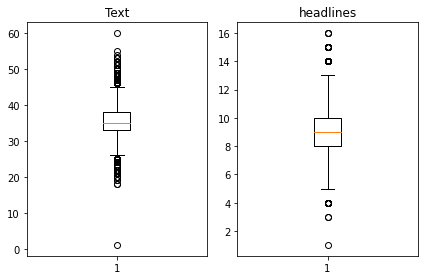

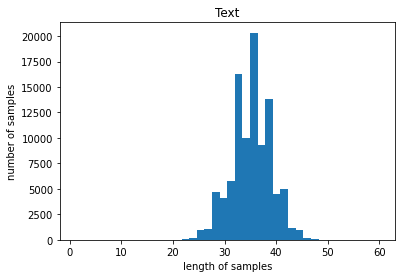

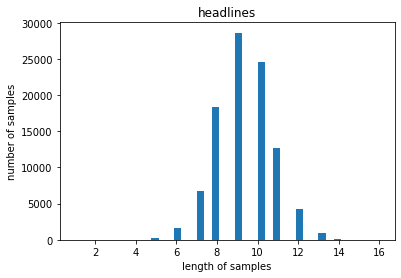

In [17]:
# 4. 훈련데이터와 테스트데이터 나누기 - 샘플의 최대 길이 정하기
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(headlines_len)))
print('제목의 최대 길이 : {}'.format(np.max(headlines_len)))
print('제목의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
# 4. 훈련데이터와 테스트데이터 나누기 - data 분석 후 임의로 정의  
text_max_len = 42
headlines_max_len = 12
text_min_len = 1
headlines_min_len = 4
print('=3')

=3


In [19]:
# 4. 훈련데이터와 테스트데이터 나누기 - 전체 data 비율 확인 함수 정의 ... maxlen
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [20]:
# 4. 훈련데이터와 테스트데이터 나누기 - 전체 data 비율 확인 함수 정의   ... minlen
def below_threshold_len(min_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= min_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(min_len, (cnt / len(nested_list))))
print('=4')

=4


In [21]:
# 4. 훈련데이터와 테스트데이터 나누기 - 전체 비율 확인 함수 실행 .. 인정
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 42 이하인 샘플의 비율: 0.9750305002033347
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [22]:
# 4. 훈련데이터와 테스트데이터 나누기 - 전체 비율 확인 함수 실행 .. 인정
below_threshold_len(text_min_len, data['text'])
below_threshold_len(headlines_min_len,  data['headlines'])

전체 샘플 중 길이가 1 이하인 샘플의 비율: 1.0166734444896299e-05
전체 샘플 중 길이가 4 이하인 샘플의 비율: 0.0001728344855632371


In [23]:
# 4. 훈련데이터와 테스트데이터 나누기 - 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) > headlines_min_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 94737


In [24]:
data.reset_index()

,index,headlines,text
0,0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
2,3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
3,5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...
4,6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...
...,...,...,...
94732,98396,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...
94733,98397,first song from sonakshi sinha noor titled uff...,uff yeh first song sonakshi sinha starrer upco...
94734,98398,the matrix film to get reboot reports,according reports new version science fiction ...
94735,98399,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...


In [25]:
# 4. 훈련데이터와 테스트데이터 나누기 - 시작 토큰과 종료 토큰 추가하기 .. summary 추가 
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [26]:
# 4. 훈련데이터와 테스트데이터 나누기 ...디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [27]:
# 4. 훈련데이터와 테스트데이터 나누기 .. 나누기 사전(1) .. 정수 sequence
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[66097 80530 27131 ... 93764 73041 91266]


In [28]:
# 4. 훈련데이터와 테스트데이터 나누기 .. 나누기 사전(2) .. supple
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [29]:
# 4. 훈련데이터와 테스트데이터 나누기 .. 나누기 비율 정의 
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18947


In [30]:
# 4. 훈련데이터와 테스트데이터 나누기 .. 나누기 
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 75790
훈련 레이블의 개수 : 75790
테스트 데이터의 개수 : 18947
테스트 레이블의 개수 : 18947


     5. 정수 인코딩
        - 단어 집합(vocabulary)
        - 빈도수가 낮은 단어들은 훈련 데이터에서 제외 :
          . src_vocab = 20000
          . tar_vocab = 12000
        - 빈 data 제거 : text, summary
        - padding            

In [31]:
#5 정수 인코딩  - 단어 집합(vocabulary) .. Keras의 토크나이저를 사용,입력된 훈련 데이터로부터 단어 집합.encoder_input_train
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [32]:
#5 정수 인코딩  .. 빈도수 적은 단어 확인  .. src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장 encoder_input_train
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67864
등장 빈도가 6번 이하인 희귀 단어의 수: 46201
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21663
단어 집합에서 희귀 단어의 비율: 68.07880466815985
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.549109828321601


In [33]:
#5 정수 인코딩  .. 단어장 크기 임의 지정 .. 위 통계 data 확인   encoder_input_train
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [34]:
#5 정수 인코딩  ..  ??????????이 넘는 숫자들은 정수 인코딩 후에는 데이터에 미존재  encoder_input_train
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[160, 19, 466, 8613, 1213, 479, 972, 10032, 1048, 50, 1281, 3, 13, 64, 501, 3841, 16274, 76, 621, 5830, 305, 121, 231, 3040, 184, 7437, 343, 96, 11538, 501, 793, 11241, 6597], [216, 1654, 4418, 2308, 242, 8, 13955, 4023, 743, 17029, 278, 21, 1049, 600, 56, 216, 231, 3997, 1645, 17029, 17, 1992, 97, 1654, 7660, 1128, 1111, 2825], [4447, 4389, 572, 346, 2309, 173, 1, 1698, 2027, 229, 913, 554, 319, 21, 331, 2560, 66, 229, 434, 21, 104, 675, 1763, 312, 554, 919, 173, 1, 4, 25, 7542, 676]]


In [35]:
#5 정수 인코딩  - 단어 집합(vocabulary) .. Keras의 토크나이저를 사용,입력된 훈련 데이터로부터 단어 집합.decoder_input_train
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [36]:
#5 정수 인코딩  .. 빈도수 적은 단어 확인  .. src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장decoder_input_train
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29576
등장 빈도가 3번 이하인 희귀 단어의 수: 16649
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12927
단어 집합에서 희귀 단어의 비율: 56.29226399783608
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.2383916550177756


In [37]:
#5 정수 인코딩  .. 단어장 크기 임의 지정 .. 단어장 다시 만들고 ... 다시 정수화... decoder_input_train , decoder_target_train
tar_vocab = 12000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 64, 291, 6019, 678, 3, 685, 1560, 4, 142, 66], [1, 86, 1785, 1606, 3, 60, 5, 11, 997], [1, 8, 321, 686, 1221, 199, 232, 2212, 2299], [1, 435, 20, 80, 5, 4562, 6, 625, 121], [1, 817, 3, 227, 299, 4859, 580, 61]]
target
decoder  [[64, 291, 6019, 678, 3, 685, 1560, 4, 142, 66, 2], [86, 1785, 1606, 3, 60, 5, 11, 997, 2], [8, 321, 686, 1221, 199, 232, 2212, 2299, 2], [435, 20, 80, 5, 4562, 6, 625, 121, 2], [817, 3, 227, 299, 4859, 580, 61, 2]]


In [38]:
#5 정수 인코딩  ..정수화된 data엣 빈 data 삭제 
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75790
훈련 레이블의 개수 : 75790
테스트 데이터의 개수 : 18947
테스트 레이블의 개수 : 18947


In [39]:
#5 정수 인코딩  .... 패딩하기 
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


    6. 모델 설계
        - encoder : input > emb > lstm1 > lstm2 > lstm3
        - decoder  
          . 입력층 : input > embding > lstm
          . 출력층 : attention > decoder_concat_input > softmax > output

In [40]:
#6 모델 설계 .... encoder
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [41]:
#6 모델 설계 .... decoder input 
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [42]:
#6 모델 설계 .... decoder output ... 어텐션 메커니즘 .. 위에서 설계한 디코더의 출력층을 수정
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)


In [43]:
#6 모델 설계 .... 마지막 모델
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

    7. 모델 훈련 
       - compile & fit
         . EarlyStopping : val_loss(검증 손실)을 관찰,  검증 손실이 증가하는 현상 2회(patience=2) 관측 ,학습 멈춤
       - 시각화

In [44]:
#7 모델 훈련 .... compile & fit
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)  

Epoch 1/50
297/297 [==============================] - 56s 99ms/step - loss: 5.7649 - val_loss: 5.3866
Epoch 2/50
297/297 [==============================] - 29s 98ms/step - loss: 5.1918 - val_loss: 5.0196
Epoch 3/50
297/297 [==============================] - 30s 102ms/step - loss: 4.8473 - val_loss: 4.7766
Epoch 4/50
297/297 [==============================] - 31s 104ms/step - loss: 4.5793 - val_loss: 4.5726
Epoch 5/50
297/297 [==============================] - 30s 102ms/step - loss: 4.3690 - val_loss: 4.4084
Epoch 6/50
297/297 [==============================] - 31s 103ms/step - loss: 4.1980 - val_loss: 4.3316
Epoch 7/50
297/297 [==============================] - 31s 103ms/step - loss: 4.0513 - val_loss: 4.2247
Epoch 8/50
297/297 [==============================] - 31s 103ms/step - loss: 3.9224 - val_loss: 4.1691
Epoch 9/50
297/297 [==============================] - 31s 103ms/step - loss: 3.8075 - val_loss: 4.0784
Epoch 10/50
297/297 [==============================] - 31s 103ms/step - los

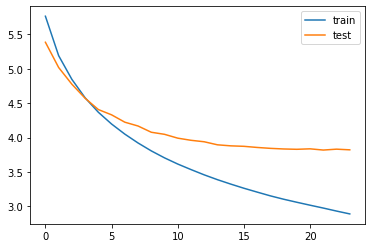

In [45]:
#7 모델 훈련 ... 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

    8. 인퍼런스 모델 
       - encoder
       - 어텐션 함수
       - sequence 출력     

In [46]:
#8 인퍼런스 모델 ... src_tokenizer > list
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [47]:
#8 인퍼런스 모델 ..... # 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [48]:
#8 인퍼런스 모델 ..... # 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [49]:
#8 인퍼런스 모델 ..... # sequence
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


    9. 모델 테스트
       - 텍스트 변환 함수 : 텍스트 시퀀스로 변환하여 결과를 확인 함수
       - 테스트 실시

In [50]:
#9 model test  .. 텍스트 변환 함수
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [51]:
#9 model test  .. 실시 50개
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : hollywood actor chris hemsworth shared instagram story wish fans occasion diwali actor said happy everybody india shooting wonderful day namaste video shows hemsworth dressed kurta also features bollywood actor randeep hooda 
실제 요약 : namaste happy wood actor shares video on diwali 
예측 요약 :  my father is not my film on the world day chris


원문 : police arrested two men carrying demonetised currency notes worth lakh suv belonging former samajwadi party minister lucknow monday claimed former minister asked get old notes replaced unknown person police also recovered minister revolver confirming association arrested persons 
실제 요약 : old currency worth lakh seized from up ex minister suv 
예측 요약 :  up man arrested for stealing notes worth lakh


원문 : lucknow metro broke wednesday morning first day opened public reportedly leaving around people stranded hour lights air conditioner went due technical glitch could rectified passengers evacuated emergency gates train towed away 
실제 요약 : luck

In [52]:
#10. 추출적요약  - data load  summer 라이브러리
import requests
from summa.summarizer import summarize 
from summa import summarizer

In [64]:
data_summarize.text[0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [65]:
for i in range(10, 20):
    print(data_summarize.text[i])
    print("추출 예측 요약1 :",summarize(data_summarize.text[i], ratio=0.8))
    print("추출 예측 요약2 :",summarize(data_summarize.text[i], words=20))
    print("\n")

Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.
추출 예측 요약1 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.
추출 예측 요약2 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.


Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren in Jharkhand for several decades. Chaibasa-based Ghosh reportedly walks seven kilometres daily